In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np

std_path = os.path.join(
    os.path.dirname('__file__'),
    'out/out_data_std.csv'
)

sbs_path = os.path.join(
    os.path.dirname('__file__'),
    'out/out_data_sbs.csv'
)

chs_path = os.path.join(
    os.path.dirname('__file__'),
    'out/out_data_chs.csv'
)

In [6]:
std_data = pd.read_csv(std_path)
chs_data = pd.read_csv(chs_path)
sbs_data = pd.read_csv(sbs_path)

In [16]:
colors_std = [{p>=300: (0.5,0.5,0.5, 0.2), p<300: '#522A27'}[True] for p in std_data["solve time"].to_list()]
colors_sbs = [{p>=300: (0.5,0.5,0.5, 0.2), p<300: '#C73E1D'}[True] for p in sbs_data["solve time"].to_list()]
colors_chs = [{p>=300: (0.5,0.5,0.5, 0.2), p<300: '#C59849'}[True] for p in chs_data["solve time"].to_list()]
std_patch = mpatches.Patch(color='#522A27', label="Standard Solver")
sbs_patch = mpatches.Patch(color='#C73E1D', label="Simmetry Breaking solver")
chs_patch = mpatches.Patch(color='#C59849', label="Cumulative Height solver")
over5_patch = mpatches.Patch(color=(0.5,0.5,0.5,0.2), label="Over 5 min execution")

In [22]:
total_std_time = sum(std_data['solve time'].to_list())
total_sbs_time = sum(sbs_data['solve time'].to_list())
total_chs_time = sum(chs_data['solve time'].to_list())
mean_std = total_std_time/40
mean_sbs = total_sbs_time/40
mean_chs = total_chs_time/40

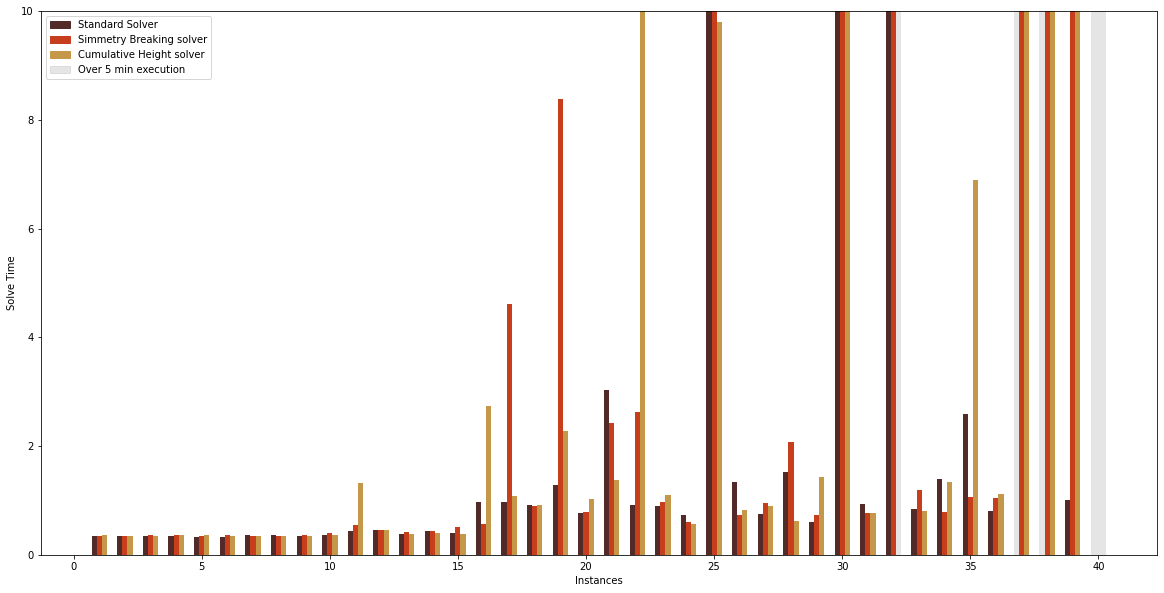

######################################################
Total std solving time: 1038.3371646404266
Total sbs solving time: 823.318555355072
Total chs solving time: 766.7291491031647

mean std solving time: 25.958429116010667
mean sbs solving time: 20.5829638838768
mean chs solving time: 19.168228727579116
######################################################


In [23]:
width=0.2
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(40)
rect1 = ax.bar(index- width +1, std_data['solve time'].to_list(), width, color=colors_std)
rect2 = ax.bar(index +1, sbs_data['solve time'].to_list(), width, color=colors_sbs)
rect3 = ax.bar(index + width +1, chs_data['solve time'].to_list(), width, color=colors_chs)

ax.set_ylabel("Solve Time")
ax.set_xlabel("Instances")
ax.set_ylim(0, 10)
ax.legend(handles=[std_patch, sbs_patch, chs_patch, over5_patch])

plt.show()

print("######################################################")
print("Total std solving time: {}".format(total_std_time))
print("Total sbs solving time: {}".format(total_sbs_time))
print("Total chs solving time: {}".format(total_chs_time))
print()
print("mean std solving time: {}".format(mean_std))
print("mean sbs solving time: {}".format(mean_sbs))
print("mean chs solving time: {}".format(mean_chs))
print("######################################################")
